# **Ley de Benford.**

Para este ejercicio se toman datos del censo de población de 2020 realizado por el INEGI en el estado de Jalisco. El dataset es muy detallado, cuenta con 256 campos de más de 10,000 localidades. Para este ejercicio sólo son necesarias pocas columnas incluso puede realizarse sólo con la columna de población de la localidad.

In [5]:
import math
import numpy as np
import pandas as pd
import scipy.stats as st
#import seaborn as sns
import matplotlib.pyplot as plt
#pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

In [6]:
df = pd.read_csv('sample_data/conjunto_de_datos_iter_14CSV20.csv', encoding='utf-8', header=0, parse_dates= True)
df.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
0,14,Jalisco,0,Total de la entidad Jalisco,0,Total de la Entidad,NaN,NaN,NaN,8348151,...,2134429,1437473,1199700,573528,375678,56399,96948,760439,17553,*
1,14,Jalisco,0,Total de la entidad Jalisco,9998,Localidades de una vivienda,NaN,NaN,NaN,12686,...,2247,497,1016,94,80,556,607,2256,317,*
2,14,Jalisco,0,Total de la entidad Jalisco,9999,Localidades de dos viviendas,NaN,NaN,NaN,10843,...,2003,431,911,70,62,439,519,1994,249,*
3,14,Jalisco,1,Acatic,0,Total del Municipio,NaN,NaN,NaN,23175,...,5801,2877,3585,482,464,121,310,3193,40,*
4,14,Jalisco,1,Acatic,1,Acatic,"102°54'19.000"" W","20°46'46.000"" N",1693.0,13033,...,3293,1940,2530,387,318,54,161,1545,17,7


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10715 entries, 0 to 10714
Columns: 286 entries, ENTIDAD to TAMLOC
dtypes: float64(1), int64(6), object(279)
memory usage: 23.4+ MB


In [8]:
df_covid = pd.read_csv('sample_data/03-09-2023.csv', encoding='utf-8', header=0, parse_dates= True)
df_covid.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-03-10 04:21:03,33.93911,67.709953,209451,7896,NaN,NaN,Afghanistan,538.042451,3.769855
1,NaN,NaN,NaN,Albania,2023-03-10 04:21:03,41.15330,20.168300,334457,3598,NaN,NaN,Albania,11621.968170,1.075774
2,NaN,NaN,NaN,Algeria,2023-03-10 04:21:03,28.03390,1.659600,271496,6881,NaN,NaN,Algeria,619.132366,2.534476
3,NaN,NaN,NaN,Andorra,2023-03-10 04:21:03,42.50630,1.521800,47890,165,NaN,NaN,Andorra,61981.492267,0.344540
4,NaN,NaN,NaN,Angola,2023-03-10 04:21:03,-11.20270,17.873900,105288,1933,NaN,NaN,Angola,320.352770,1.835917


In [9]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3268 non-null   float64
 1   Admin2               3272 non-null   object 
 2   Province_State       3837 non-null   object 
 3   Country_Region       4016 non-null   object 
 4   Last_Update          4016 non-null   object 
 5   Lat                  3925 non-null   float64
 6   Long_                3925 non-null   float64
 7   Confirmed            4016 non-null   int64  
 8   Deaths               4016 non-null   int64  
 9   Recovered            0 non-null      float64
 10  Active               0 non-null      float64
 11  Combined_Key         4016 non-null   object 
 12  Incident_Rate        3922 non-null   float64
 13  Case_Fatality_Ratio  3974 non-null   float64
dtypes: float64(7), int64(2), object(5)
memory usage: 439.4+ KB


In [10]:
df_filter = df[['NOM_MUN', 'NOM_LOC', 'ALTITUD', 'POBTOT']]
df_filter.columns = ['Municipio', 'Localidad', 'Altitud', 'Población']

In [11]:
df_filter.dropna(axis = 0, inplace = True)
df_filter.drop('Altitud', axis = 1, inplace = True)
df_filter.reset_index(inplace = True)
loc_tot = df_filter.shape[0]
loc_tot

10348

In [12]:
def primer_digito(x):
  while x > 0:
    i = x % 10
    x = x // 10
  return i

In [13]:
df_filter['Digito'] = df_filter['Población'].apply(primer_digito)
df_filter.head(10)

,index,Municipio,Localidad,Población,Digito
0,4,Acatic,Acatic,13033,1
1,5,Acatic,Agua Prieta (Tepetates),221,2
2,6,Acatic,Alacates,7,7
3,7,Acatic,El Bajío de los Herrera,31,3
4,8,Acatic,El Bañadero,1,1
5,9,Acatic,Rancho Nuevo Calderón,235,2
6,10,Acatic,El Capadero (San Miguel de la Loza),16,1
7,11,Acatic,Carricillo,40,4
8,12,Acatic,Ceja de Ramblas,75,7
9,13,Acatic,Cofradía Grande,56,5


En la primera columna se muestran los dígitos con los que inician cantidades validas, es decir, de 1 a 9. En la segunda columna están las frecuencias observadas de cada digito. En la columna tres están las frecuencias esperadas según la ley de Benford. Las columnas 4 y 5 no son necesarias, pero me pareció interesante ponerlas para comparar los porcentajes observados (columna 4) con los porcentajes esperados de la Ley de Benford (columna 5). La sexta columna contiene el cálculo del estadístico de prueba según la formula arriba citada.

In [14]:
df_table_freq = pd.DataFrame()
df_table_freq['Frecuencia absoluta'] = pd.DataFrame(df_filter['Digito'].value_counts().sort_index())
df_table_freq["Frecuencia absoluta acumulada"] = df_table_freq['Frecuencia absoluta'].cumsum()
df_table_freq["Frecuencia relativa"] = df_filter['Digito'].value_counts(normalize = True)
df_table_freq["Porcentaje"] = round(df_table_freq['Frecuencia relativa'] * 100, 2).astype(str)+' %'
df_table_freq["Frecuencia relativa acumulada"] = round(df_table_freq['Frecuencia absoluta'].cumsum() / df_table_freq['Frecuencia absoluta'].sum(), 4)
df_table_freq["Porcentaje acumulado"] = round(df_table_freq["Frecuencia relativa acumulada"] * 100, 4).astype(str)+' %'
df_table_freq

,Frecuencia absoluta,Frecuencia absoluta acumulada,Frecuencia relativa,Porcentaje,Frecuencia relativa acumulada,Porcentaje acumulado
Digito,,,,,,
1,2985,2985,0.288462,28.85 %,0.2885,28.85 %
2,1943,4928,0.187766,18.78 %,0.4762,47.62 %
3,1231,6159,0.118960,11.9 %,0.5952,59.52 %
4,1074,7233,0.103788,10.38 %,0.6990,69.9 %
5,922,8155,0.089099,8.91 %,0.7881,78.81 %
6,669,8824,0.064650,6.47 %,0.8527,85.27 %
7,577,9401,0.055760,5.58 %,0.9085,90.85 %
8,464,9865,0.044840,4.48 %,0.9533,95.33 %
9,483,10348,0.046676,4.67 %,1.0000,100.0 %


In [15]:
#benford = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]
benford = np.array(range(9), dtype = float)
for i in np.arange(1, 10, 1):
  benford[i-1]=(round((math.log10(i+1)-math.log10(i))*100, 2))
benford

array([30.1 , 17.61, 12.49,  9.69,  7.92,  6.69,  5.8 ,  5.12,  4.58])

In [16]:
array_benford = np.array(range(9), dtype = float)
for i in range(9):
  #r = loc_tot * b
  array_benford[i] = loc_tot * benford[i] / 100
array_benford

array([3114.748 , 1822.2828, 1292.4652, 1002.7212,  819.5616,  692.2812,
        600.184 ,  529.8176,  473.9384])

In [17]:
df_table_x2 = pd.DataFrame()
df_table_x2['Frecuencia observada'] = pd.DataFrame(df_filter['Digito'].value_counts().sort_index())
df_table_x2['Frecuencia esperada'] = array_benford
df_table_x2['Porcentaje observado'] = round(df_filter['Digito'].value_counts(normalize = True) * 100, 2)
df_table_x2['Porcentaje esperado'] = benford
df_table_x2['Estadístico de prueba'] = round((df_table_x2['Frecuencia observada'] - df_table_x2['Frecuencia esperada'])**2 / df_table_x2['Frecuencia esperada'], 4)
df_table_x2

,Frecuencia observada,Frecuencia esperada,Porcentaje observado,Porcentaje esperado,Estadístico de prueba
Digito,,,,,
1,2985,3114.7480,28.85,30.10,5.4048
2,1943,1822.2828,18.78,17.61,7.9969
3,1231,1292.4652,11.90,12.49,2.9231
4,1074,1002.7212,10.38,9.69,5.0669
5,922,819.5616,8.91,7.92,12.8040
6,669,692.2812,6.47,6.69,0.7829
7,577,600.1840,5.58,5.80,0.8956
8,464,529.8176,4.48,5.12,8.1763
9,483,473.9384,4.67,4.58,0.1733


In [18]:
df_table_x2['Frecuencia observada'].sum()

np.int64(10348)

In [19]:
chi2 = df_table_x2['Estadístico de prueba'].sum()
chi2

np.float64(44.2238)

In [20]:
#Valor critico
alpha = 0.05 #nivel de significancia
crit = st.chi2.ppf(q = 1-alpha, df = len(df_table_x2)-1)
crit

np.float64(15.50731305586545)

In [21]:
if chi2 > crit:
  print("Rechazamos H0")
else:
  print("No hay evidencias para rechazar H0")

Rechazamos H0


In [22]:
p_val = 1-st.chi2.cdf(x=chi2, df = len(df_table_x2)-1)
p_val

np.float64(5.161569806011457e-07)

In [23]:
if p_val < alpha:
  print("Rechazamos H0")
else:
  print("No hay evidencias para rechazar H0")

Rechazamos H0


In [24]:
st.chisquare(f_obs = df_table_x2['Frecuencia observada'], f_exp=df_table_x2['Frecuencia esperada'])

Power_divergenceResult(statistic=np.float64(44.22367102708357), pvalue=np.float64(5.16185962782145e-07))

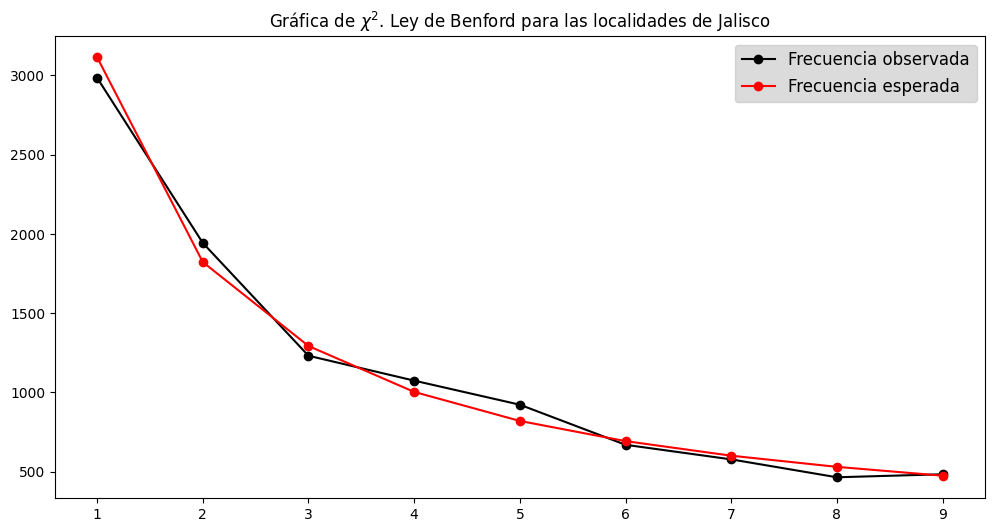

In [25]:
plt.subplots(figsize = (12, 6))
plt.title(r'Gráfica de $\chi^{2}$. Ley de Benford para las localidades de Jalisco')
plt.plot( df_table_x2.index, df_table_x2['Frecuencia observada'], label = 'Frecuencia observada', marker='o',  color = 'k')
plt.plot( df_table_x2.index, df_table_x2['Frecuencia esperada'], label = 'Frecuencia esperada', marker='o',  color = 'r')
plt.legend(loc = 'upper right', frameon = True, fontsize = 12, facecolor = 'lightgray')
plt.show()

In [26]:
df_loc_filter = (df_filter[(df_filter['Población'] < 100)]).copy(deep = True)
df_loc_filter.shape[0]#/loc_tot

8256

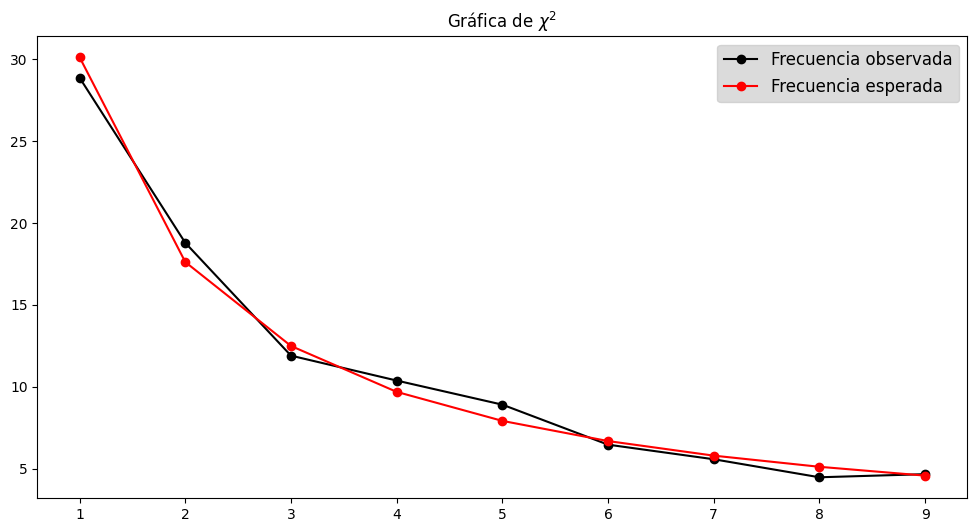

In [27]:
plt.subplots(figsize = (12, 6))
plt.title(r'Gráfica de $\chi^{2}$')
plt.plot( df_table_x2.index, df_table_x2['Porcentaje observado'], label = 'Frecuencia observada', marker='o',  color = 'k')
plt.plot( df_table_x2.index, df_table_x2['Porcentaje esperado'], label = 'Frecuencia esperada', marker='o',  color = 'r')
plt.legend(loc = 'upper right', frameon = True, fontsize = 12, facecolor = 'lightgray')
plt.show()

In [28]:
def first_digit(x):
  if x > 0:
    while x > 0:
      i = x % 10
      x = x // 10
  else:
    i = 0
  return i

In [29]:
df_c = df_covid[['Country_Region', 'Confirmed', 'Deaths']]
df_c.drop(df_c[(df_c['Confirmed'] == 0)].index, inplace=True)
#df_c.reset_index(inplace = True)
reg_tot = df_filter.shape[0]
df_c['Digit_C'] = df_c['Confirmed'].apply(first_digit)
#df_c['Digit_D'] = df_c['Deaths'].apply(first_digit)
df_c

,Country_Region,Confirmed,Deaths,Digit_C
0,Afghanistan,209451,7896,2
1,Albania,334457,3598,3
2,Algeria,271496,6881,2
3,Andorra,47890,165,4
4,Angola,105288,1933,1
...,...,...,...,...
4011,West Bank and Gaza,703228,5708,7
4012,Winter Olympics 2022,535,0,5
4013,Yemen,11945,2159,1
4014,Zambia,343135,4057,3


In [30]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3974 entries, 0 to 4015
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country_Region  3974 non-null   object
 1   Confirmed       3974 non-null   int64 
 2   Deaths          3974 non-null   int64 
 3   Digit_C         3974 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 155.2+ KB


In [31]:
array_benford = np.array(range(9), dtype = float)
for i in range(9):
  array_benford[i] = df_c.shape[0] * benford[i] / 100
array_benford

array([1196.174 ,  699.8214,  496.3526,  385.0806,  314.7408,  265.8606,
        230.492 ,  203.4688,  182.0092])

In [32]:
df_c_table_x2 = pd.DataFrame()
df_c_table_x2['Frecuencia observada'] = pd.DataFrame(df_c['Digit_C'].value_counts().sort_index())
df_c_table_x2['Frecuencia esperada'] = array_benford
df_c_table_x2['Porcentaje observado'] = round(df_c['Digit_C'].value_counts(normalize = True) * 100, 2)
df_c_table_x2['Porcentaje esperado'] = benford
df_c_table_x2['Estadístico de prueba'] = round((df_c_table_x2['Frecuencia observada'] - df_c_table_x2['Frecuencia esperada'])**2 / df_c_table_x2['Frecuencia esperada'], 4)
df_c_table_x2

,Frecuencia observada,Frecuencia esperada,Porcentaje observado,Porcentaje esperado,Estadístico de prueba
Digit_C,,,,,
1,1231,1196.1740,30.98,30.10,1.0139
2,685,699.8214,17.24,17.61,0.3139
3,438,496.3526,11.02,12.49,6.8601
4,376,385.0806,9.46,9.69,0.2141
5,340,314.7408,8.56,7.92,2.0272
6,289,265.8606,7.27,6.69,2.0140
7,242,230.4920,6.09,5.80,0.5746
8,197,203.4688,4.96,5.12,0.2057
9,176,182.0092,4.43,4.58,0.1984


In [33]:
chi2 = df_c_table_x2['Estadístico de prueba'].sum()
chi2

np.float64(13.4219)

In [34]:
#Valor critico
alpha = 0.05 #nivel de significancia
crit = st.chi2.ppf(q = 1-alpha, df = len(df_c_table_x2)-1)
crit

np.float64(15.50731305586545)

In [35]:
if chi2 > crit:
  print("Rechazamos H0")
else:
  print("No hay evidencias para rechazar H0")

No hay evidencias para rechazar H0


In [36]:
p_val = 1-st.chi2.cdf(x=chi2, df = len(df_c_table_x2)-1)
p_val

np.float64(0.09813436670612474)

In [37]:
if p_val < alpha:
  print("Rechazamos H0")
else:
  print("No hay evidencias para rechazar H0")

No hay evidencias para rechazar H0


In [38]:
st.chisquare(f_obs = df_c_table_x2['Frecuencia observada'], f_exp = df_c_table_x2['Frecuencia esperada'])

Power_divergenceResult(statistic=np.float64(13.421804697386891), pvalue=np.float64(0.09813728919415106))

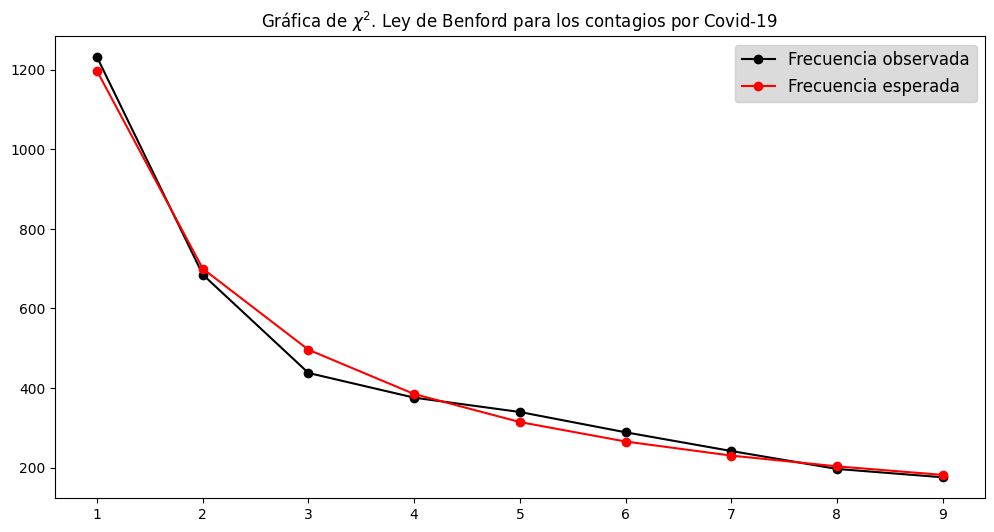

In [39]:
plt.subplots(figsize = (12, 6))
plt.title(r'Gráfica de $\chi^{2}$. Ley de Benford para los contagios por Covid-19 ')
plt.plot( df_c_table_x2.index, df_c_table_x2['Frecuencia observada'], label = 'Frecuencia observada', marker='o',  color = 'k')
plt.plot( df_c_table_x2.index, df_c_table_x2['Frecuencia esperada'], label = 'Frecuencia esperada', marker='o',  color = 'r')
plt.legend(loc = 'upper right', frameon = True, fontsize = 12, facecolor = 'lightgray')
plt.show()

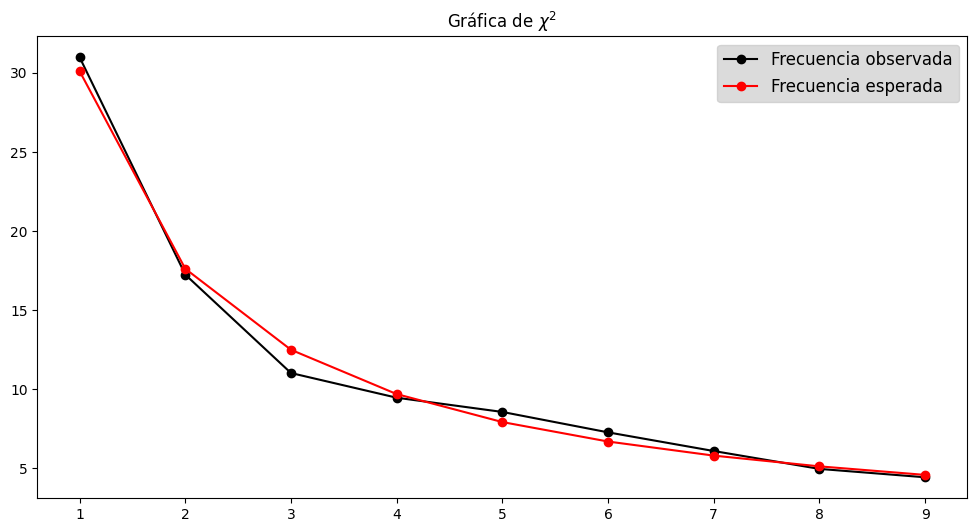

In [40]:
plt.subplots(figsize = (12, 6))
plt.title(r'Gráfica de $\chi^{2}$')
plt.plot( df_c_table_x2.index, df_c_table_x2['Porcentaje observado'], label = 'Frecuencia observada', marker='o',  color = 'k')
plt.plot( df_c_table_x2.index, df_c_table_x2['Porcentaje esperado'], label = 'Frecuencia esperada', marker='o',  color = 'r')
plt.legend(loc = 'upper right', frameon = True, fontsize = 12, facecolor = 'lightgray')
plt.show()

In [41]:
df_d = df_covid[['Country_Region', 'Confirmed', 'Deaths']]
df_d.drop(df_d[(df_d['Deaths'] == 0)].index, inplace=True)
#df_d.reset_index(inplace = True)
reg_tot = df_filter.shape[0]
#df_d['Digit_C'] = df_d['Confirmed'].apply(first_digit)
df_d['Digit_D'] = df_d['Deaths'].apply(first_digit)
df_d

,Country_Region,Confirmed,Deaths,Digit_D
0,Afghanistan,209451,7896,7
1,Albania,334457,3598,3
2,Algeria,271496,6881,6
3,Andorra,47890,165,1
4,Angola,105288,1933,1
...,...,...,...,...
4010,Vietnam,11526994,43186,4
4011,West Bank and Gaza,703228,5708,5
4013,Yemen,11945,2159,2
4014,Zambia,343135,4057,4


In [42]:
df_d_table_x2 = pd.DataFrame()
df_d_table_x2['Frecuencia observada'] = pd.DataFrame(df_d['Digit_D'].value_counts().sort_index())
df_d_table_x2['Frecuencia esperada'] = array_benford
df_d_table_x2['Porcentaje observado'] = round(df_d['Digit_D'].value_counts(normalize = True) * 100, 2)
df_d_table_x2['Porcentaje esperado'] = benford
df_d_table_x2['Estadístico de prueba'] = round((df_d_table_x2['Frecuencia observada'] - df_d_table_x2['Frecuencia esperada'])**2 / df_d_table_x2['Frecuencia esperada'], 4)
df_d_table_x2

,Frecuencia observada,Frecuencia esperada,Porcentaje observado,Porcentaje esperado,Estadístico de prueba
Digit_D,,,,,
1,1247,1196.1740,32.38,30.10,2.1596
2,634,699.8214,16.46,17.61,6.1908
3,455,496.3526,11.82,12.49,3.4452
4,341,385.0806,8.85,9.69,5.0460
5,299,314.7408,7.76,7.92,0.7872
6,258,265.8606,6.70,6.69,0.2324
7,234,230.4920,6.08,5.80,0.0534
8,201,203.4688,5.22,5.12,0.0300
9,182,182.0092,4.73,4.58,0.0000


In [43]:
chi2 = df_d_table_x2['Estadístico de prueba'].sum()
chi2

np.float64(17.9446)

In [44]:
#Valor critico
alpha = 0.05 #nivel de significancia
crit = st.chi2.ppf(q = 1-alpha, df = len(df_d_table_x2)-1)
crit

np.float64(15.50731305586545)

In [45]:
if chi2 > crit:
  print("Rechazamos H0")
else:
  print("No hay evidencias para rechazar H0")

Rechazamos H0


In [46]:
p_val = 1-st.chi2.cdf(x=chi2, df = len(df_d_table_x2)-1)
p_val

np.float64(0.021645684877105165)

In [47]:
if p_val < alpha:
  print("Rechazamos H0")
else:
  print("No hay evidencias para rechazar H0")

Rechazamos H0


In [48]:
#st.chisquare(f_obs = df_d_table_x2['Frecuencia observada'], f_exp = df_d_table_x2['Frecuencia esperada'])

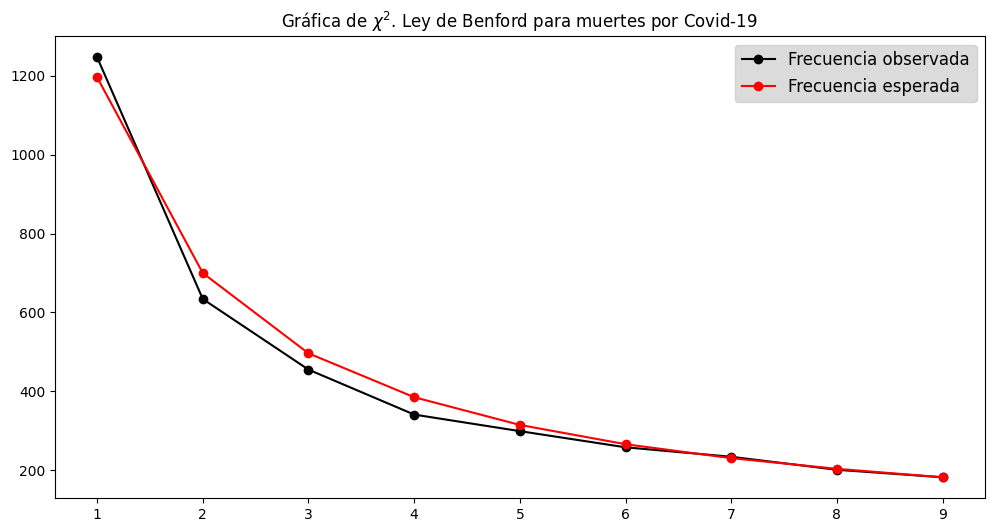

In [49]:
plt.subplots(figsize = (12, 6))
plt.title(r'Gráfica de $\chi^{2}$. Ley de Benford para muertes por Covid-19')
plt.plot( df_d_table_x2.index, df_d_table_x2['Frecuencia observada'], label = 'Frecuencia observada', marker='o',  color = 'k')
plt.plot( df_d_table_x2.index, df_d_table_x2['Frecuencia esperada'], label = 'Frecuencia esperada', marker='o',  color = 'r')
plt.legend(loc = 'upper right', frameon = True, fontsize = 12, facecolor = 'lightgray')
plt.show()

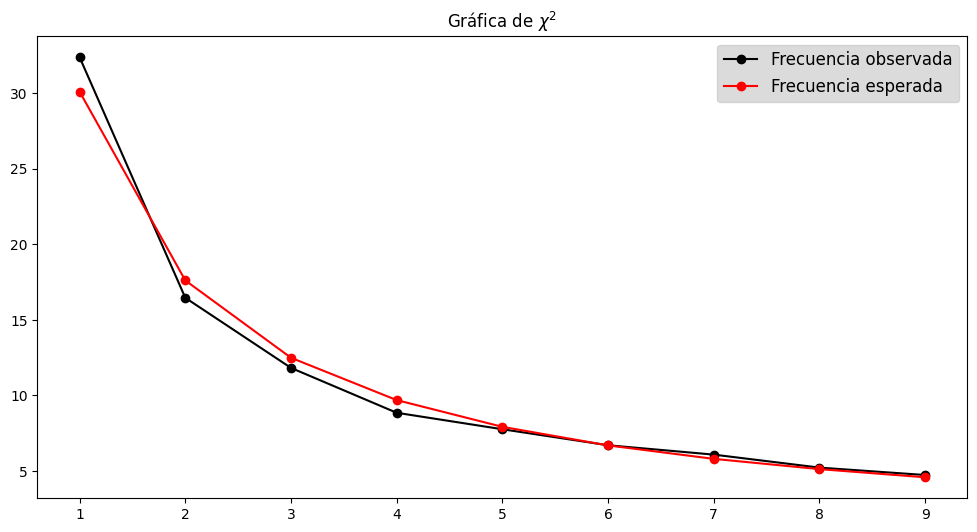

In [50]:
plt.subplots(figsize = (12, 6))
plt.title(r'Gráfica de $\chi^{2}$')
plt.plot( df_d_table_x2.index, df_d_table_x2['Porcentaje observado'], label = 'Frecuencia observada', marker='o',  color = 'k')
plt.plot( df_d_table_x2.index, df_d_table_x2['Porcentaje esperado'], label = 'Frecuencia esperada', marker='o',  color = 'r')
plt.legend(loc = 'upper right', frameon = True, fontsize = 12, facecolor = 'lightgray')
plt.show()

In [51]:
for i in range(9):
  print(math.log10(1+(1/(i+1))))

0.3010299956639812
0.17609125905568124
0.12493873660829992
0.09691001300805642
0.07918124604762482
0.06694678963061322
0.05799194697768673
0.05115252244738129
0.04575749056067514


In [52]:
for i in range(9):
  print(round((math.log10(i+2)-math.log10(i+1))*100, 2))

30.1
17.61
12.49
9.69
7.92
6.69
5.8
5.12
4.58


In [53]:
mu = 0
sigma = 1
alpha = 0.5
data = np.random.normal(loc = mu, scale = sigma, size = 100)
stat, p = st.kstest(data, 'norm')
if p > alpha:
  print('No hay elementos para rechazar H0')
else:
  print('Hay elementos para rechazar H0')

No hay elementps para rechazar H0
